In [ ]:
#Upload Dataset to Notebook
#Dataset Source: https://covidamp.org/data?type=policy
#Dataset Name: CovidAMPDataset.xlsx

# from google.colab import files

# uploaded = files.upload()

In [ ]:
# imports for policy classfication model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
nltk.download('stopwords') 
nltk.download('wordnet')

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Preparing the data
# Read data from GitHub
df = pd.read_excel("https://github.com/carllcox/VIP/blob/fall20group4/CovidAMPDataset.xlsx?raw=true", sheet_name='Policies', header=6, usecols="O,P,R")

# Read uploaded data
# data = pd.ExcelFile("CovidAMPDataset.xlsx")
# df = data.parse(sheet_name='Policies', header=6, usecols="O,P,R")


print('Policy categories:')
#for idx, cat in enumerate(set(df[''])):
#  print(idx+1, cat)
# print('Total number of policy categories: ', len(set(df['Policy category'])))
# print('Total number of policy subcategories: ', len(set(df['Policy subcategory'])))

df.head(5)

#Next Step: Converting to numpy...


Policy categories:


,Policy category,Policy subcategory,Policy description
0,Enabling and relief measures,Other relief measures,The percentage to be applied to the RWA amount...
1,Enabling and relief measures,Other relief measures,The percentage to be applied to the RWA amount...
2,Enabling and relief measures,Other relief measures,The percentage to be applied to the RWA amount...
3,Social distancing,Other forms of social distancing,Public employers (including school districts) ...
4,Social distancing,Alternative election measures,Polling locations must follow public health me...


In [ ]:
# Split data into train and test set; validation done using k-fold cross validation
x_train, x_test, y_train, y_test = train_test_split(df['Policy description'], df['Policy category'], test_size=0.2, random_state=123)
print(f'Train dimensions: {x_train.shape, y_train.shape}')
print(f'Test dimensions: {x_test.shape, y_test.shape}')
# Check out target distribution
print(y_train.value_counts())
print(y_test.value_counts())

Train dimensions: ((12355,), (12355,))
Test dimensions: ((3089,), (3089,))
Social distancing                                  7610
Enabling and relief measures                       1973
Support for public health and clinical capacity    1152
Emergency declarations                              557
Travel restrictions                                 466
Authorization and enforcement                       358
Contact tracing/Testing                             196
Military mobilization                                43
Name: Policy category, dtype: int64
Social distancing                                  1853
Enabling and relief measures                        504
Support for public health and clinical capacity     301
Emergency declarations                              162
Travel restrictions                                 118
Authorization and enforcement                        84
Contact tracing/Testing                              51
Military mobilization                            

In [ ]:
# Stephanie Chang
# Reference: https://towardsdatascience.com/introduction-to-nlp-part-4-supervised-text-classification-model-in-python-96e9709b4267
def preprocess_text(text):
    """
    INPUT:
      text - pandas.Series - text to be tokenized (x_train, x_test: policy description)
    OUTPUT:
      keywords - list - list of tokenized keywords with out stopwords
    """
    # Tokenise words while ignoring punctuation
    # (separating a piece of text into smaller units called tokens)
    tokeniser = RegexpTokenizer(r'\w+')
    tokens = tokeniser.tokenize(text)
    
    # Lowercase and lemmatise 
    lemmatiser = WordNetLemmatizer()
    lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
    
    # Remove stop words
    keywords= [lemma for lemma in lemmas if lemma not in stopwords.words('english')]
    return keywords

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=preprocess_text)
# Fit to the data and transform to feature matrix
x_train_tfidf = vectorizer.fit_transform(x_train)
x_train_tfidf.shape
x_test_tfidf = vectorizer.fit_transform(x_test)
x_test_tfidf.shape

(3089, 5861)

In [ ]:
# Stephanie Chang
# Grid search to determine best hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
parameters = {'alpha': [1, 1.5, 2]}
# Build Multinomial Naive Bayes Classifier model
mnb_clf = MultinomialNB()
clf = GridSearchCV(mnb_clf, parameters)
clf.fit(x_train_tfidf, y_train)
# 5 fold cross validation (using f1 micro-averaged score metric, since our dataset does not have balanced categories)
clf_scores = cross_val_score(clf, x_train_tfidf, y_train, cv=5, scoring='f1_micro')
print(clf_scores)
print("Train Accuracy: %0.2f (+/- %0.2f)" % (clf_scores.mean(), clf_scores.std() * 2))
clf_scores = cross_val_score(clf, x_test_tfidf, y_test, cv=5, scoring='f1_micro')
print(clf_scores)
print("Test Accuracy: %0.2f (+/- %0.2f)" % (clf_scores.mean(), clf_scores.std() * 2))
# Predict
clf_pred = cross_val_predict(clf, x_test_tfidf, y_test, cv=5)
# Evaluate predictions with confusion matrix
conf_mat = confusion_matrix(y_test, clf_pred)
print(conf_mat)
# print classification report 
print(classification_report(y_test, clf_pred, zero_division=1))


[0.78065561 0.78348847 0.78551194 0.78470255 0.78632133]
Train Accuracy: 0.78 (+/- 0.00)
[0.68608414 0.67152104 0.67961165 0.66990291 0.68233387]
Test Accuracy: 0.68 (+/- 0.01)
[[   0    0    0   10    0   74    0    0]
 [   0    0    0    1    0   50    0    0]
 [   0    0   10    3    0  149    0    0]
 [   0    0    0  190    0  313    1    0]
 [   0    0    0    3    0   12    1    0]
 [   0    0    0    4    0 1849    0    0]
 [   0    0    0   22    0  237   42    0]
 [   0    0    0    1    0  114    0    3]]
                                                 precision    recall  f1-score   support

                  Authorization and enforcement       1.00      0.00      0.00        84
                        Contact tracing/Testing       1.00      0.00      0.00        51
                         Emergency declarations       1.00      0.06      0.12       162
                   Enabling and relief measures       0.81      0.38      0.51       504
                          Milita

In [ ]:
# **** Logistic Regression Model - Peter Feng ****

# Quick Links: 
# https://kavita-ganesan.com/news-classifier-with-logistic-regression-in-python/
# https://developers.google.com/machine-learning/crash-course
# https://www.debuggex.com/cheatsheet/regex/python
# https://github.com/kavgan/nlp-in-practice/blob/master/text-classification/notebooks/Text%20Classification%20with%20Logistic%20Regression.ipynb


# Imports
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
import re  #Import regular expression functionality
import pandas as pd
import logging 
import numpy as np


# **Preparing the Data** 


# Read Dataset.
# Using Categories: Policy category, Policy subcategory, Policy subtarget, Policy description, Data source for policy announcement, and Policy/law name.
lrmdf = pd.read_excel("https://github.com/carllcox/VIP/blob/fall20group4/CovidAMPDataset.xlsx?raw=true", sheet_name='Policies', header=6, usecols="O,P,Q,R,Y,Z")



#Create tokenized URLs. 
#Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens, perhaps at the same time throwing away certain characters, such as punctuation.
#Might not end up using urls for training.  Looks like there is too much garbage data.  
#print(lrmdf["Data source for policy announcement"])

def tokenize_url(url:str):   
  if isinstance(url, str): #We can only tokenize strings.
    #url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(https|http|www|com|net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)+", "", url)
    url=re.sub("(\W|_)+", " ", url) #Searches(enclosed in parentheses for capturing group) for \W (a non-word character) or (denoted by |) an underscore(_) one or more times (+).  Replaces them with spaces.
    print(url)
  return url

#lrmdf['tokenized_url']=lrmdf['Data source for policy announcement'].apply(lambda x:tokenize_url(x)) #Lambda function takes in column entry as x and returns a tokenized version of x.  
#print(lrmdf["Data source for policy announcement"])


#Create field containing just the policy description
lrmdf['text_desc'] = lrmdf['Policy description']

#Create field containing policy description + policy/law name
lrmdf['text_desc_name'] = lrmdf['Policy description'] + ' ' + lrmdf['Policy/law name']

#Handle NaN Values
lrmdf = lrmdf.dropna()

# GET A TRAIN TEST SPLIT (set seed for consistent results)
training_data, testing_data = train_test_split(lrmdf,random_state = 2000)

# GET LABELS
Y_train=training_data['Policy category'].values
Y_test=testing_data['Policy category'].values

#Feature extraction function
def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""
    
    logging.info("Extracting features and creating vocabulary...")
    
    if "binary" in type:
        
        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
  
    elif "counts" in type:
        
        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)
        
        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,cv
    
    else:    
        
        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)
        
        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        
        return train_feature_set,test_feature_set,tfidf_vectorizer


# GET FEATURES
field = 'text_desc_name'
feature_rep = 'binary'
top_k = 1 

X_train,X_test,feature_transformer=extract_features(lrmdf, field, training_data,testing_data,type=feature_rep)



#Define function to get predictions
def get_top_k_predictions(model,X_test,k):
    
  # get probabilities instead of predicted labels, since we want to collect top 3
  probs = model.predict_proba(X_test)

  # GET TOP K PREDICTIONS BY PROB - note these are just index
  best_n = np.argsort(probs, axis=1)[:,-k:]
      
  # GET CATEGORY OF PREDICTIONS
  preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
      
  # REVERSE CATEGORIES - DESCENDING ORDER OF IMPORTANCE
  preds=[ item[::-1] for item in preds]
      
  return preds


def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list


def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    mrr = 0
    for item in items:   
      rr_at_k = _reciprocal_rank(item[0],item[1])
      rr_total = rr_total + rr_at_k
      mrr = rr_total / 1/float(len(items))

    return mrr

def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
    
    
    accuracy=correct/float(len(eval_items))
    return accuracy


# INIT LOGISTIC REGRESSION CLASSIFIER
logging.info("Training a Logistic Regression Model...")
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(X_train,Y_train)


# GET TOP K PREDICTIONS
preds=get_top_k_predictions(model,X_test,top_k)
    
# GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS
eval_items=collect_preds(Y_test,preds)
    
# GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
logging.info("Starting evaluation...")
accuracy=compute_accuracy(eval_items)
mrr_at_k=compute_mrr_at_k(eval_items)


#MRR = accuracy if k=1 otherwise, accuracy just returns binary values if the correct answer was predicted regardless or order, while MRR is lower because it "deducts" for not computing the correct answer in the first try.
print("Accuracy:", accuracy, " Mean Reciprocal Rank with {0} predictions: ".format(top_k), mrr_at_k, "\n")


#Mean Reciprocal Rank https://en.wikipedia.org/wiki/Mean_reciprocal_rank
#This is a way of accounting for the possibility of multiple "correct" responses by generating a list of ranked predicted categories and taking into account where in the list the correct response is.  

#    (1/|Q|)*Sum(i=1 to Q, 1/Ranki).    i is the current training entry being predicted, Q is the total of training entries, Ranki is the "Rank" of the correct response in the results for this training entry i.  

#Formula finds the mean of the reciprocal ranks.  Rank is the position of the correct response in a list of multiple predicted categories. Since the formula is the mean of 1/Rank, or the reciprocal of the rank,
#if the correct response is in the first position, the reciprocal rank is 1/Rank = 1/1 = 1, if the correct response is in the 2nd position, the reciprocal rank is 1/Rank = 1/2, etc.  
#Therefore, the greater the mean reciprocal rank, the more accurate the model.  

#I assume the formula uses the reciprocal rank, not the rank, to set the bounds to be from 0 to 1.  


#Todo: lemmatise data







#Test the model! 

#https://cortlandvoice.com/2020/10/28/suny-adopts-system-wide-policy-requiring-all-on-campus-students-to-test-negative-for-covid-19-prior-to-thanksgiving-break/

test_features=feature_transformer.transform(["""As colleges and universities prepare to wind down in-person classes and activities ahead of Thanksgiving, 
State University of New York Chancellor Jim Malatras announced that SUNY has adopted a policy mandating all students using on-campus facilities in 
any capacity test negative for COVID-19 within the 10 days prior to leaving campus. Campuses must develop schedules that conduct the test as close to a student's 
departure date as possible. That means SUNY's 64 colleges and universities will test about 140,000 students over a 10-day period preceding Thanksgiving break. 
With COVID-19 cases reaching record highs nationwide, this testing requirement will help prevent community spread as students return to their hometowns. Colleges 
and universities must submit a plan to test all of their on-campus students within that 10-day window no later than November 5."""])

#Print all possible labels:
def unique(list1): 
      
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set)) 
    return unique_list

#Print all possible categories:
print(*unique(Y_train), sep="\n")

print(get_top_k_predictions(model,test_features,2))




[LibLinear]Accuracy: 0.9076354679802956  Mean Reciprocal Rank with 1 predictions:  0.9076354679802956 

Emergency declarations
Military mobilization
Travel restrictions
Contact tracing/Testing
Social distancing
Enabling and relief measures
Support for public health and clinical capacity
Authorization and enforcement
[['Social distancing', 'Contact tracing/Testing']]


In [ ]:
policy1 = """use some tax dollars to fund vaccine research"""
policy2 = """Develop a virus that causes the exact opposite symtoms of coronavirus so that anyone who is infected doesn’t get affected."""
policy3 = """If you have covid, wear a sombrero of sufficient size to be seen so people will know not to get under the sombrero. 6’ sombrero?"""
policy4 = """Generate interesting zoom games for kids to stay entertained at Thanksgiving without their relatives visiting"""

listofpolicies = [policy1, policy2, policy3, policy4]

for policy in listofpolicies:
  print(policy)
  print(get_top_k_predictions(model, feature_transformer.transform([policy]), 2))


use some tax dollars to fund vaccine research
[['Enabling and relief measures', 'Social distancing']]
Develop a virus that causes the exact opposite symtoms of coronavirus so that anyone who is infected doesn’t get affected.
[['Enabling and relief measures', 'Social distancing']]
If you have covid, wear a sombrero of sufficient size to be seen so people will know not to get under the sombrero. 6’ sombrero?
[['Social distancing', 'Support for public health and clinical capacity']]
Generate interesting zoom games for kids to stay entertained at Thanksgiving without their relatives visiting
[['Social distancing', 'Support for public health and clinical capacity']]


In [ ]:

# Salil Kamath
# Random Forest

# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import regex as re

# Import data
data = pd.read_excel("https://github.com/carllcox/VIP/blob/fall20group4/CovidAMPDataset.xlsx?raw=true", sheet_name='Policies', header=6, usecols="O,R")


# Source https://towardsdatascience.com/build-and-compare-3-models-nlp-sentiment-prediction-67320979de61
# Process the text
corpus = []
def processData(policy):
  # Removes everything except letters from the policy
  policy = re.sub('^a-zA-Z', ' ', policy)
  # Makes the policy lowercase and splits it into array
  policy = policy.lower()
  policy = policy.split()
  # Separates stems of words in the policies and removes stopwords
  ps = PorterStemmer()
  policy = [ps.stem(word) for word in policy if not word in set(stopwords.words('english'))]
  policy = ' '.join(policy)
  return policy
# Appends to list of policies
for i in data['Policy description']:  
  corpus.append(processData(i))


In [ ]:
# Salil Kamath
# Imports for splitting data
from sklearn.feature_extraction.text import CountVectorizer

# Bag of Words model with 1500 words
cv = CountVectorizer(max_features = 1500)
# Sets X and Y to the processed policies and categories respectively
X = cv.fit_transform(corpus).toarray()
Y = data['Policy category'].values
# Splits data into train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Random forest classifier to train
rfclf = RandomForestClassifier(n_estimators = 200, criterion = 'gini', random_state = 0)
rfclf.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
# Salil Kamath
# Predictions for test results
Y_pred_RF = rfclf.predict(X_test)
print(Y_pred_RF)
# Prints training scores using 5 fold cross validation
# rfclf_scores = cross_val_score(rfclf, X_train, Y_train, cv=5, scoring='f1_micro')
# print(rfclf_scores)
# print("Train Accuracy: %0.2f (+/- %0.2f)" % (rfclf_scores.mean(), rfclf_scores.std() * 2))

# Prints training scores using 5 fold cross validation
# rfclf_scores = cross_val_score(rfclf, X_test, Y_test, cv=5, scoring='f1_micro')
# print(rfclf_scores)
# print("Test Accuracy: %0.2f (+/- %0.2f)" % (rfclf_scores.mean(), rfclf_scores.std() * 2))

# Prints Confusion Matrix
cm_RF = confusion_matrix(Y_test, Y_pred_RF)
print(cm_RF)


['Social distancing' 'Social distancing' 'Social distancing' ...
 'Social distancing' 'Emergency declarations' 'Social distancing']
[[  47    0    1   23    0   26    7    0]
 [   0   31    0    2    1   10    4    1]
 [   0    0  134    4    0    9    0    2]
 [   0    1    4  379    0   81   11    2]
 [   0    0    2    3    3    0    1    0]
 [   1    2    5   18    0 1825    6   10]
 [   1    1    2   26    0   65  203    1]
 [   0    0    2    1    0   30    1  100]]


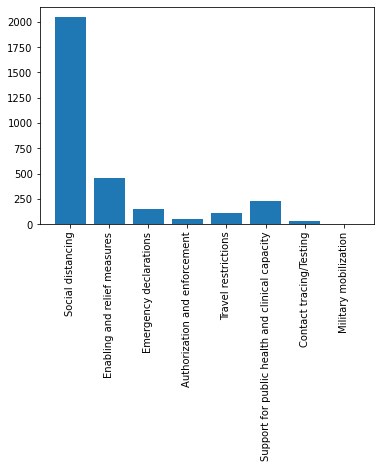

In [ ]:
from collections import Counter
def plot_classifcation_results(prediction):
    fig, ax = plt.subplots(1, 1)
    c = Counter(prediction)

    ax.bar(c.keys(), c.values())
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.show()

plot_classifcation_results(Y_pred_RF)

In [ ]:
# def demo(classifier, input):
#     cv = CountVectorizer(max_features = 40)
#     input = processData([input])
#     input = cv.fit_transform(input).toarray()
#     result = classifier.predict(input)
#     print("The predicted category of the policy is", result)

# policy = input()
# demo(rfclf, policy)

More classification models to try:
*   Logistic Regression
*   (Multinomial) Naive Bayes
*   Linear Support Vector Machine
*   Random Forest

Tutorials and other useful links:

https://towardsdatascience.com/seven-clean-steps-to-reshape-your-data-with-pandas-or-how-i-use-python-where-excel-fails-62061f86ef9c 

https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971 

https://machinelearningmastery.com/how-to-prepare-data-for-machine-learning/

https://www.tensorflow.org/hub/tutorials/tf2_text_classification

https://covidamp.org/data?type=policy